# Red Alerts in Israel. 2 years of war

## Project Description

This project analyzes the **temporal and spatial patterns** of red alerts in Israel, covering the period from **December 26, 2018, to October 5, 2025**. The study examines **alert frequency, timing trends, geographical distribution, and alarm types**, providing insights into escalation dynamics and regional impact.

The dataset is sourced from the [Cumta Telegram channel](https://t.me/CumtaAlertsEnglishChannel), and insights are presented through visualizations, heatmaps, and geospatial models.

### Research Plan

1. **🛠️ Data Preparation**
2. **📅 Temporal Analysis**
3. **⏰ Analysis of Alert Timing and Weekly Patterns**
4. **🏙️ Cities and Localities with the Highest and Lowest Number of Alerts**
5. **🚀 Types of Alarms**
6. **🗺️ Geospatial Analysis**
7. **✅ General Conclusion**


### Data

---

1. `detailed_df` - Each string represents an alert recorded in a specific district (including city neighborhoods). This approach provides a more accurate estimate of the affected area.

- **Total rows:** 111421
- **Duplicates:** None  
- **Time column (`'time'`):** Converted to `datetime64[ns]` format  
- **Missing value** None  

**Columns:**

| Column Name | Description |
|-------------|------------|
| **datetime** | Date and time of the warning in `datetime64[ns]` format |
| **locality** | Name of the locality (city, town, or settlement) |
| **region** | Region to which the locality belongs |
| **threat_type** | Type of warning. Possible values: `'Red Alert'`, `'Unrecognized Aircraft'`, `'Terrorist Infiltration'`, `'Interception Pieces'`, `'Earthquake'` |
| **district** | Administrative district or region where the locality is located; an official governmental division. |

---

2. `df` - Each string represents an alert event per city, even if it was heard in multiple neighborhoods within two minutes. This method ensures a more accurate count of alerts by city.

- **Total rows:** 79695
- **Duplicates:** None  
- **Time column (`'time'`):** Converted to `datetime64[ns]` format  
- **Missing value** None  

**Columns:**

| Column Name | Description |
|-------------|------------|
| **datetime** | Date and time of the warning in `datetime64[ns]` format |
| **locality** | Name of the locality (city, town, or settlement). Each alert represents a single siren event per city, even if it was heard in multiple neighborhoods within two minutes.|
| **zones** | Zones within a locality. If the locality is not a major city, this column contains `'All'` |
| **region** | Region to which the locality belongs |
| **threat_type** | Type of warning. Possible values: `'Red Alert'`, `'Unrecognized Aircraft'`, `'Terrorist Infiltration'`, `'Interception Pieces'`, `'Earthquake'` |
| **district** | Administrative district or region where the locality is located; an official governmental division. |



We will use `df` to count the cities affected by attacks.  

In other cases, where understanding the number of impacted zones and the exact locations of triggered alerts is more important, we will use `detailed_df`

---

## 🛠️ Data Preparation


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
from scipy.interpolate import make_interp_spline
from statsmodels.tsa.seasonal import seasonal_decompose
import json
import time
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap

In [2]:
prepare_df = pd.read_csv('cumta_df.csv', parse_dates=['datetime'])

In [3]:
prepare_df

,datetime,locality,zones,region,threat_type
0,2018-12-26 10:05:01,Adanim,All,Sharon 143,Red Alert
1,2018-12-26 10:05:01,Azur,All,Dan 162,Red Alert
2,2018-12-26 10:05:01,Bat Yam,All,Dan 165,Red Alert
3,2018-12-26 10:05:01,Beit Berl,All,Sharon 141,Red Alert
4,2018-12-26 10:05:01,Bnei Brak,All,Dan 160,Red Alert
...,...,...,...,...,...
79690,2025-10-05 04:58:41,Yish'i,All,Shfelat Yehuda,Red Alert
79691,2025-10-05 04:58:41,Zanoah,All,Shfelat Yehuda,Red Alert
79692,2025-10-05 04:58:41,Zeitan,All,HaShfela,Red Alert
79693,2025-10-05 04:58:41,Zrifin Industrial Zone,All,HaShfela,Red Alert


In [4]:
prepare_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79695 entries, 0 to 79694
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     79695 non-null  datetime64[ns]
 1   locality     79695 non-null  object        
 2   zones        79695 non-null  object        
 3   region       79695 non-null  object        
 4   threat_type  79695 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 3.0+ MB


In [5]:
prepare_detailed_df = pd.read_csv('cumta_detailed_df.csv', parse_dates=['datetime'])

In [6]:
prepare_detailed_df

,datetime,region,locality,threat_type,district
0,2018-12-26 10:05:01,Dan 158,Tel Aviv (South West),Red Alert,Tel Aviv District
1,2018-12-26 10:05:01,Dan 156,Tel Aviv (North),Red Alert,Tel Aviv District
2,2018-12-26 10:05:01,Dan 157,Tel Aviv (Central),Red Alert,Tel Aviv District
3,2018-12-26 10:05:01,Dan 159,Tel Aviv (South East),Red Alert,Tel Aviv District
4,2018-12-26 10:05:01,Dan 162,Azur,Red Alert,Tel Aviv District
...,...,...,...,...,...
111416,2025-06-20 15:44:15,Arava,Elipaz and Timna Mines,Red Alert,Southern District
111417,2025-06-20 15:44:15,Arava,Samar,Red Alert,Southern District
111418,2025-06-20 15:44:15,Arava,Six Senses Shaharut Hotel,Red Alert,Southern District
111419,2025-06-20 15:44:15,Arava,Ardanel Ranch,Red Alert,Southern District


In [7]:
prepare_detailed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111421 entries, 0 to 111420
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   datetime     111421 non-null  datetime64[ns]
 1   region       111421 non-null  object        
 2   locality     111421 non-null  object        
 3   threat_type  111421 non-null  object        
 4   district     111421 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 4.3+ MB


All the necessary data preprocessing is done in the previous file.

## 📅 Temporal Analysis

We will analyze the **total number of alerts per year, month, and week** to understand:
- How the **frequency of alerts has changed** over time.
- If there are **seasonal or long-term trends**.


In [8]:
# Checking the minimum and maximum dates in the dataset
print(f"Minimum date: {prepare_df['datetime'].min()}")
print(f"Maximum date: {prepare_df['datetime'].max()}")

Minimum date: 2018-12-26 10:05:01
Maximum date: 2025-10-05 18:32:20


Count the total number of alerts from December 26, 2018, to October 05, 2025.


### Annual Red Alerts Count

In [9]:
# Extract relevant time components
prepare_detailed_df['year'] = prepare_detailed_df['datetime'].dt.year

alerts_by_year = prepare_detailed_df['year'].value_counts().sort_index()

In [10]:
# 1) Define a global gradient from gray (#999999) to burgundy (#4A0012)
base_colors = ["#D3D3D3", "#CC0000", "#4A0012"]
cmap = LinearSegmentedColormap.from_list("gray-to-burgundy", base_colors)

# 2) Determine the maximum value in the dataset (the tallest bar)
max_height = alerts_by_year.values.max()

# 3) Create a vertical array [0..1] that will be stretched along the Y-axis
N = 256
vertical = np.linspace(0, 1, N).reshape(N, 1)  # shape is (256,1)


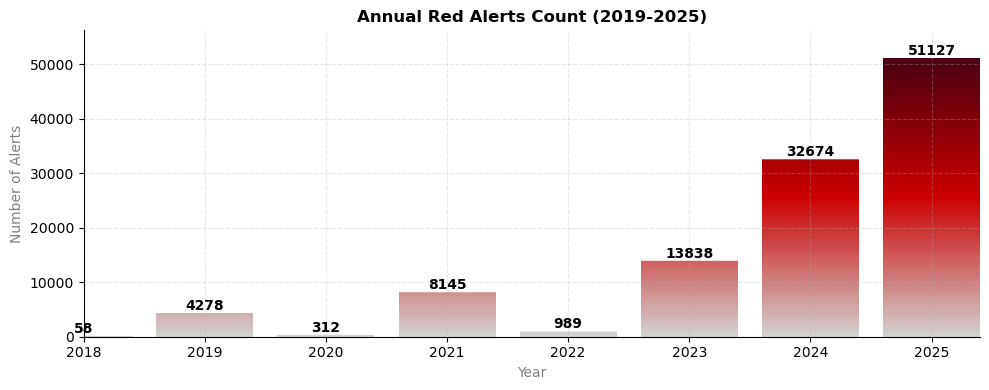

In [11]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 4))
bar_width = 0.8

# Iterate over each category (year) and its corresponding value (alerts)
for i, (year, value) in enumerate(zip(alerts_by_year.index, alerts_by_year.values)):
    # Compute the left/right edges for this bar
    left = i - bar_width / 2
    right = i + bar_width / 2

    # Create an alpha mask for the gradient:
    #   alpha=1 from y=0 up to the bar's height
    #   alpha=0 above the bar's height
    alpha_mask = np.ones((N, 1))
    for row in range(N):
        fraction = row / (N - 1)      # number in [0..1]
        y_position = fraction * max_height
        if y_position > value:
            alpha_mask[row] = 0.0

    # Draw an "image" that covers [0..max_height] with our gradient
    ax.imshow(
        vertical,
        origin='lower',      # 0 at the bottom, 1 at the top
        cmap=cmap,           # use our gray->burgundy colormap
        extent=(left, right, 0, max_height),
        aspect='auto',
        alpha=alpha_mask     # make areas above the bar's height transparent
    )

    # Place a label on top of the bar
    # Use smaller, bold font
    ax.text(
        i, value,
        str(int(value)),
        ha='center', 
        va='bottom',
        fontsize=10,         # smaller font size
        fontweight='bold'
    )

# Configure the X-axis to place ticks at the center of each bar
ax.set_xticks(range(len(alerts_by_year)))
ax.set_xticklabels(alerts_by_year.index, rotation=0)

# Extend Y-axis slightly above the tallest bar
ax.set_ylim(0, max_height * 1.1)

# Draw a horizontal dashed grid with moderate opacity
ax.yaxis.grid(True, linestyle='--', alpha=0.3)

# Draw a vertical dashed grid for columns (lower opacity)
ax.set_axisbelow(True)
ax.xaxis.grid(True, linestyle='--', alpha=0.3)

# Label the axes and set a title
ax.set_xlabel("Year", color='gray')
ax.set_ylabel("Number of Alerts", color='gray')
ax.set_title("Annual Red Alerts Count (2019-2025)", 
             fontweight='bold')

# Remove top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Auto-adjust layout to prevent label overlap
plt.tight_layout()
plt.show()


- The **number of alerts** has shown significant fluctuations over the years, with a dramatic increase in **2023 and 2024**.  
- **2025 recorded the highest number of alerts (51,127)**, marking an unprecedented escalation in hostilities.  
- The **sharp rise in 2023 (13,838 alerts)** indicates an increasing trend leading up to 2024 and 2025, likely influenced by the **October 7 war** and subsequent conflicts.  
- **Prior to 2023,** the alert frequency remained relatively lower, with spikes in **2019 (4,278 alerts) and 2021 (8,145 alerts)**, corresponding to specific escalations.  

Leave only information from October 7, 2023


In [12]:
# War period analysis
war_start = pd.Timestamp("2023-10-07")

# Create explicit copies to avoid warnings
df = prepare_df[prepare_df['datetime'] >= war_start].copy()
detailed_df = prepare_detailed_df[prepare_detailed_df['datetime'] >= war_start].copy()

In [13]:
# Extract relevant time components
detailed_df['year'] = detailed_df['datetime'].dt.year
detailed_df['month'] = detailed_df['datetime'].dt.to_period('M')  # Monthly aggregation
detailed_df['week'] = detailed_df['datetime'].dt.to_period('W')  # Weekly aggregation
detailed_df['date'] = detailed_df['datetime'].dt.date  # Extract only the date
detailed_df['hour'] = detailed_df['datetime'].dt.hour  # Extract the hour of the day

# Total alerts
total_alerts = detailed_df.shape[0]
print(f"Total alerts: {total_alerts}")


Total alerts: 96477


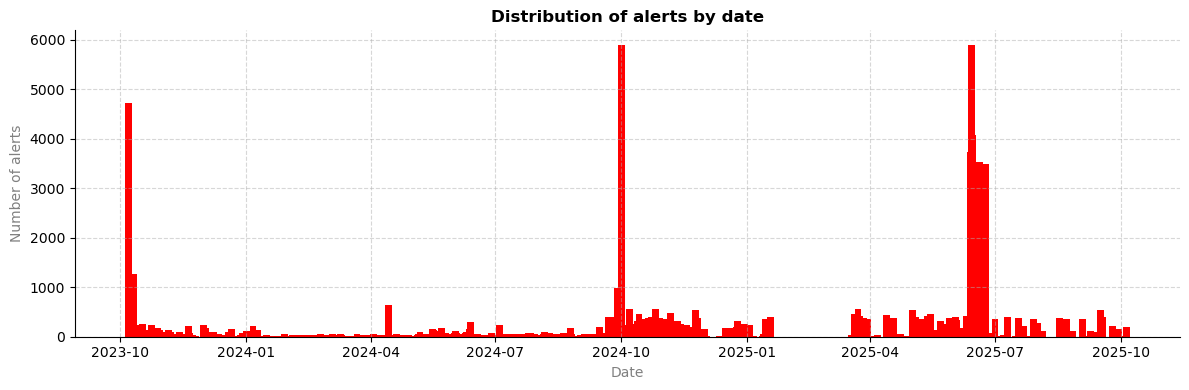

In [14]:
# Grouping by date
alerts_by_date = detailed_df['date'].value_counts().sort_index()

# Plotting the histogram
plt.figure(figsize=(12, 4))
plt.bar(alerts_by_date.index, alerts_by_date.values, color='red', width=5, alpha=1)
plt.xlabel("Date", color='gray')
plt.ylabel("Number of alerts", color='gray')
plt.title("Distribution of alerts by date", fontweight='bold')
plt.xticks(rotation=0)
plt.grid(axis='both', linestyle='--', alpha=0.5)

# Display the plot
sns.despine()
plt.tight_layout()
plt.savefig("daily.png", dpi=300, bbox_inches='tight')
plt.show()



### Number of Red Alerts Per Month

In [15]:
# Grouping by date
alerts_by_month = detailed_df['month'].value_counts().sort_index()

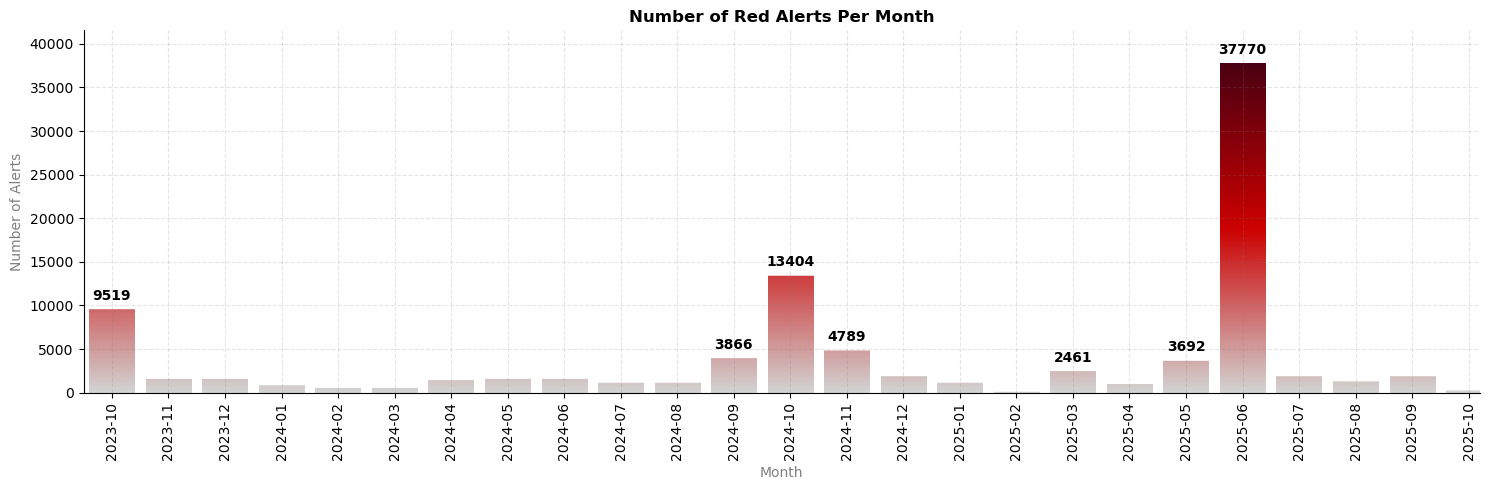

In [16]:
plt.figure(figsize=(15, 5))

# 1) Determine the global maximum alert count
max_alerts = alerts_by_month.values.max()

bar_width = 0.8
ax = plt.gca()

# 3) Plot each bar as a clipped section of the global gradient
for i, (month, value) in enumerate(zip(alerts_by_month.index, alerts_by_month.values)):
    left = i - bar_width / 2
    right = i + bar_width / 2
    
    # Build an alpha mask to hide everything above the bar's actual height
    alpha_mask = np.ones((N, 1))
    for row in range(N):
        fraction = row / (N - 1)
        y_pos = fraction * max_alerts
        if y_pos > value:
            alpha_mask[row] = 0.0
    
    ax.imshow(
        vertical,
        origin='lower',
        cmap=cmap,         # global gray->burgundy colormap
        extent=(left, right, 0, max_alerts),
        aspect='auto',
        alpha=alpha_mask
    )
    
    # Label only if above a certain threshold (optional)
    if value > 2000:
        ax.text(
            i,
            value + 0.02 * max_alerts,
            f"{int(value)}",
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='bold',
            color='black'
        )

# 4) Configure X-axis for month labels
ax.set_xticks(range(len(alerts_by_month)))
ax.set_xticklabels(alerts_by_month.index, rotation=90)

# 5) Extend the Y-axis slightly above the tallest bar
ax.set_ylim(0, max_alerts * 1.1)

# 6) Make both horizontal and vertical grid lines dashed and faint
ax.set_axisbelow(True)
ax.yaxis.grid(True, linestyle='--', alpha=0.2, color='gray')
ax.xaxis.grid(True, linestyle='--', alpha=0.2, color='gray')
ax.set_xlim(-0.5, len(alerts_by_month) - 0.8)

# 7) Label axes and set a title
ax.set_xlabel("Month", color='gray')
ax.set_ylabel("Number of Alerts", color='gray')
ax.set_title("Number of Red Alerts Per Month", 
             fontweight='bold')

# 8) Remove top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
 
# Display the plot
sns.despine()
plt.tight_layout()
plt.savefig("month.png", dpi=300, bbox_inches='tight')
plt.show()


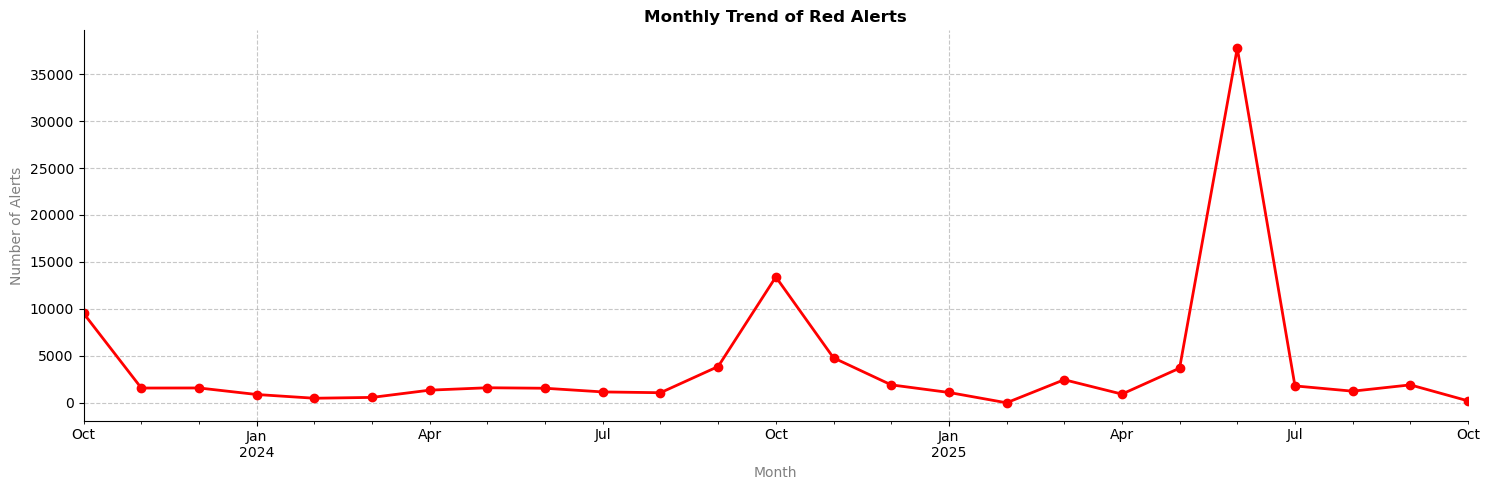

In [17]:
# Plot monthly alerts trend
plt.figure(figsize=(15, 5))
alerts_by_month.plot(kind='line', marker='o', color='red', linewidth=2)
plt.xlabel("Month", color='gray')
plt.ylabel("Number of Alerts", color='gray')
plt.title("Monthly Trend of Red Alerts", fontweight='bold')
plt.grid(axis='both', linestyle='--', alpha=0.7)
sns.despine()
plt.tight_layout()
plt.show()


The highest number of red alerts occurred within a **single month** during major escalations. In cases of **prolonged conflicts**, the **first month** typically had the most alerts, followed by a gradual decline or sustained high activity over time. This pattern is evident in  **October 2023 (9,519 alerts)**, **October 2024 (13,404 alerts)** and **June 2025 (37,770 alerts)** each marking the peak of respective conflict periods.

### Number of Red Alerts Per Week

In [18]:
# Grouping by week
alerts_by_week = detailed_df['week'].value_counts().sort_index()

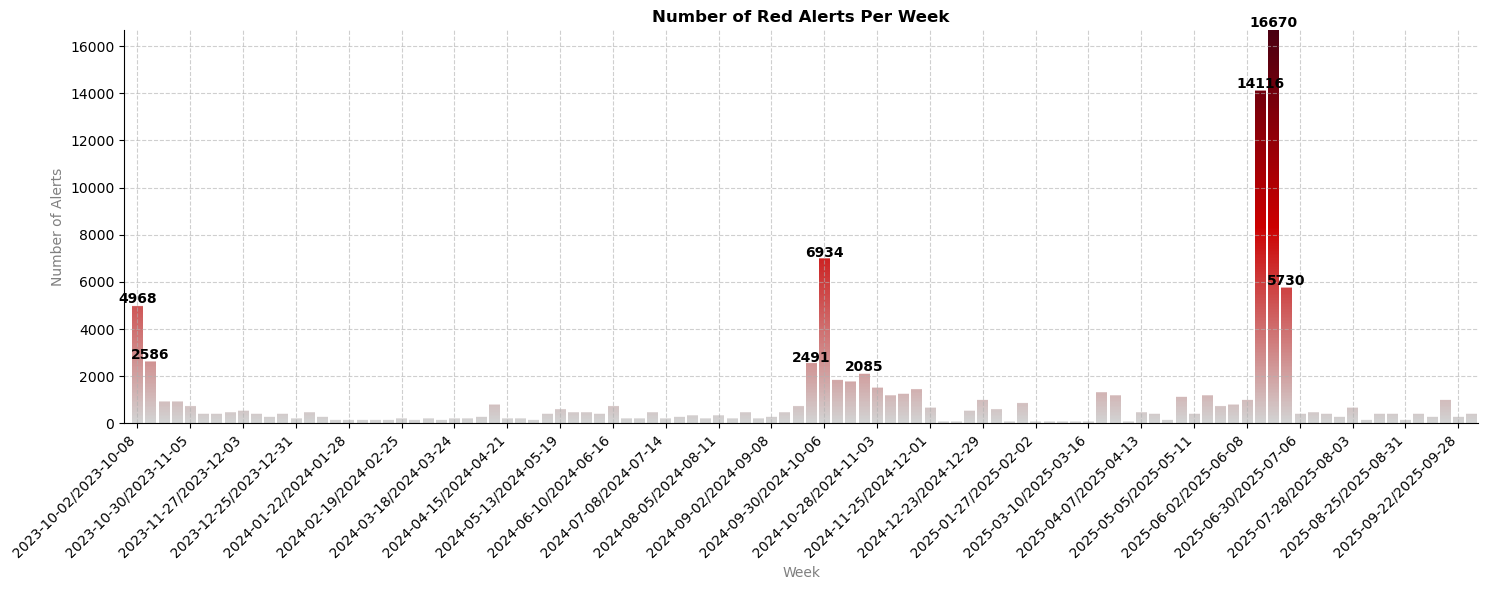

In [19]:
# Set up the figure and axis for the weekly plot
fig, ax = plt.subplots(figsize=(15, 6))

# Determine the maximum value in the weekly dataset
max_week = alerts_by_week.values.max()
bar_width = 0.8  # Width of each bar

# Iterate over each week and its corresponding alert value
for i, (week, value) in enumerate(zip(alerts_by_week.index, alerts_by_week.values)):
    # Compute left/right edges of the bar
    left = i - bar_width / 2
    right = i + bar_width / 2

    # Create an alpha mask for the gradient:
    #   alpha=1 from y=0 up to the bar's height,
    #   alpha=0 above the bar's height
    alpha_mask = np.ones((N, 1))
    for row in range(N):
        fraction = row / (N - 1)  # value in [0, 1]
        y_position = fraction * max_week
        if y_position > value:
            alpha_mask[row] = 0.0

    # Draw the gradient image for this bar using the global colormap
    ax.imshow(
        vertical,
        origin='lower',
        cmap=cmap,
        extent=(left, right, 0, max_week),
        aspect='auto',
        alpha=alpha_mask
    )

    # Annotate the bar only if the value exceeds 2000
    if value > 2000:
        ax.text(i, value, str(int(value)),
                ha='center', va='bottom',
                fontsize=10, fontweight='bold')

# Configure the X-axis to display every 4th week label to avoid overlap
ax.set_xticks(range(0, len(alerts_by_week), 4))
ax.set_xticklabels(alerts_by_week.index[::4], rotation=45, ha='right')

# Set axis labels and title
ax.set_xlabel("Week", color='gray')
ax.set_ylabel("Number of Alerts", color='gray')
ax.set_title("Number of Red Alerts Per Week", fontweight='bold')

# Add horizontal dashed grid lines for better readability
ax.grid(axis='both', linestyle='--', alpha=0.6)

# Remove unnecessary spines and grid lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.xaxis.grid(False)  # Remove vertical grid lines
ax.set_xlim(-1, len(alerts_by_week) - 0.5)

plt.tight_layout()
plt.show()


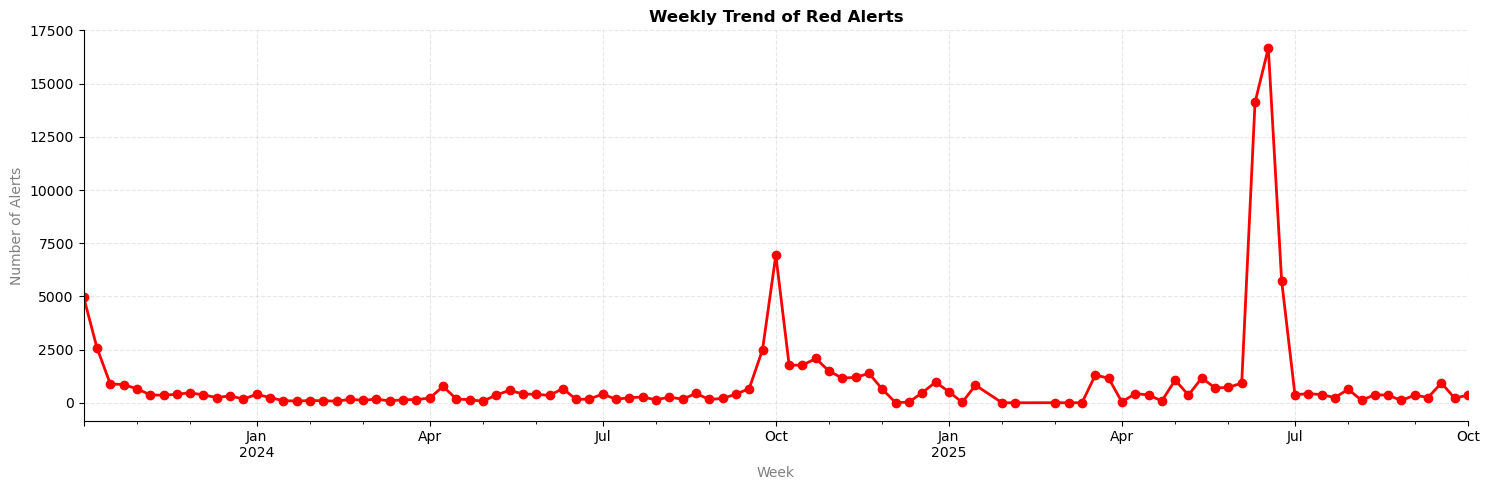

In [20]:
# Plot weekly alerts trend
plt.figure(figsize=(15, 5))
alerts_by_week.plot(kind='line', marker='o', color='red', linewidth=2)
plt.xlabel("Week", color='gray')
plt.ylabel("Number of Alerts", color='gray')
plt.title("Weekly Trend of Red Alerts", fontweight='bold')
plt.grid(axis='both', linestyle='--', alpha=0.3)
plt.xticks(rotation=0)
sns.despine()
plt.tight_layout()
plt.show()


The **highest intensity of red alerts typically occurs within a single week** during major escalations. The most significant peaks are:  k  
- **October 2023:** 4,968 alerts in one week  
- **October 2024:** 6,934 alerts in one
- **June 2025:** the sharpest surge, reaching 16,670 alerts in a single week, coincides with the Israel–Iran warpeak.

### Red Alerts Distribution by Date

### Top-10 days with the Highest Number of Alerts

In [21]:
# Group data by date and count the number of alerts per day
daily_alerts = detailed_df.groupby('date')['datetime'].count()

# Get the top 10 days with the highest number of alerts
top_10_days = daily_alerts.nlargest(10).reset_index()

# Rename columns for better readability
top_10_days.columns = ['Date', 'Number of Alerts']

# Display the result
print("Top 10 Days with the Highest Number of Alerts:")
top_10_days


Top 10 Days with the Highest Number of Alerts:


,Date,Number of Alerts
0,2025-06-14,5896
1,2024-10-01,5891
2,2023-10-07,4731
3,2025-06-15,4066
4,2025-06-13,3737
5,2025-06-20,3532
6,2025-06-22,3500
7,2025-06-24,3498
8,2025-06-16,3010
9,2025-06-19,2265


In [22]:
# Filter rows for October 7, 2023
count_oct7 = detailed_df[detailed_df['datetime'].dt.date == pd.to_datetime("2023-10-07").date()].shape[0]

print("Number of rows for October 7, 2023:", count_oct7)

Number of rows for October 7, 2023: 4731


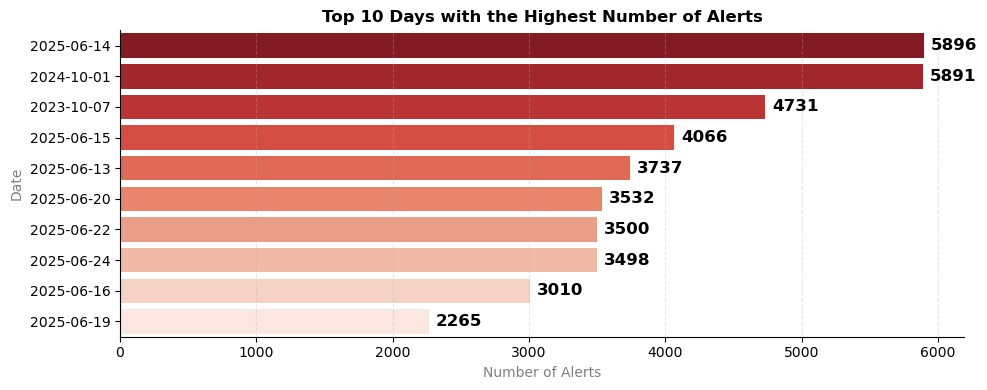

In [23]:
# Create figure
plt.figure(figsize=(10, 4))

# Create horizontal barplot
ax = sns.barplot(
    data=top_10_days, 
    y="Date", 
    x="Number of Alerts", 
    hue="Date",  # Assign hue to y-variable to use palette
    palette="Reds_r", 
    legend=False,  # Disable legend since it's redundant
    orient="h"
)

# Add numbers on top of bars
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_width())}',  # Convert number of alerts to int for clarity
        (p.get_width() + 50, p.get_y() + p.get_height() / 2),  
        ha='left', va='center', 
        fontsize=12, fontweight='bold', color='black'
    )

# Add titles and labels
plt.title("Top 10 Days with the Highest Number of Alerts", 
          fontweight="bold")
plt.xlabel("Number of Alerts", color='gray')
plt.ylabel("Date", color='gray')
plt.grid(axis="x", linestyle="--", alpha=0.3)

# Show the plot
sns.despine()
plt.tight_layout()
plt.show()



📊 **Key Findings**  

- **Total alerts:** 96477
While **the highest peak occurred on October 1, 2024**, with **5,891 alerts** corresponding to the **Iranian attack**, the most dominant feature of the top 10 list is the concentration of high-alert days in June 2025 (**The June 2025 Israel–Iran Escalation**).
**October 7, 2023**, ranks **third**, with **4,731 alerts**, marking the outbreak of the war.

---

**Annual Trends**  

- **2025** recorded the highest number of alerts (**51,127**), **2024 reached 32,674 alerts**, **2023 saw 13,838 alerts**.

**Monthly Trends**  

- Three **major peaks** in the dataset:  **October 2023 (9,519 alerts)**, **October 2024 (13,404 alerts)**,  **June 2025 (37,770 alerts)**. 

**Weekly Trends**  

The highest intensity of red alerts typically occurs within a single week during major escalations. The most significant peaks are:
- **October 2023**: 4,968 alerts in one week
- **October 2024**: 6,934 alerts in one
- **June 2025**: the sharpest surge, reaching 16,670 alerts in a single week, coincides with the Israel–Iran warpeak.

## 🏙️ Cities and localities with the highest and lowest number of alerts

This section provides an in-depth analysis of the distribution of Red Alerts across different localities, focusing on the areas most and least affected by alerts. 

### Localities with the Highest Number of Alerts
Identify localities with the most and least alerts.


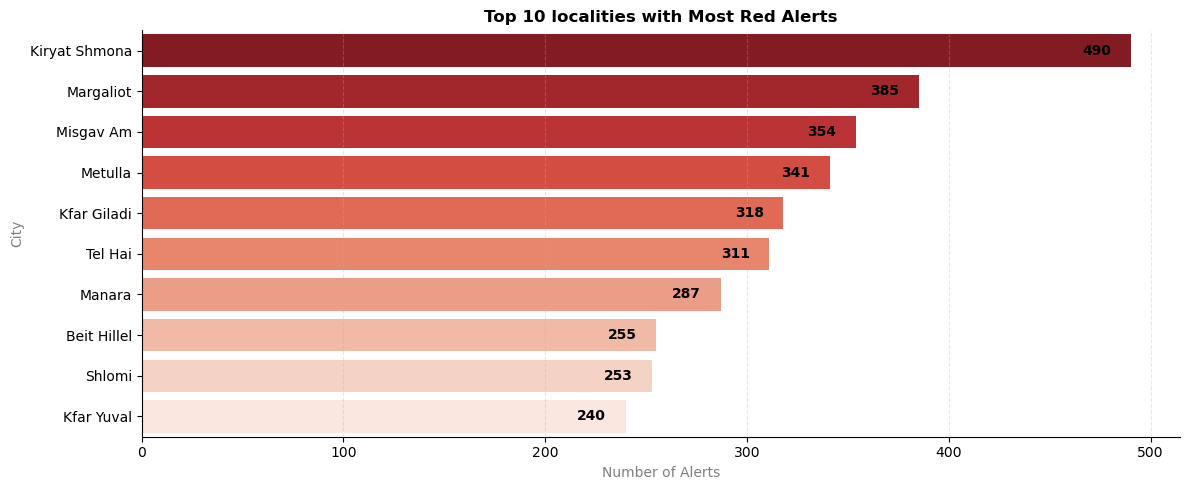

In [24]:
# Group data by city and count the number of alerts
top_localities = df['locality'].value_counts().nlargest(10)

plt.figure(figsize=(12, 5))
ax = sns.barplot(x=top_localities.values, y=top_localities.index, 
                 hue=top_localities.index, palette="Reds_r", legend=False)
plt.xlabel("Number of Alerts", color='gray')
plt.ylabel("City", color='gray')
plt.title("Top 10 localities with Most Red Alerts", fontweight='bold')
plt.grid(axis="x", linestyle="--", alpha=0.3)

offset = 0.02 * top_localities.values.max()

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    y = p.get_y() + height / 2
    ax.text(width - offset, 
            y, 
            int(width), 
            ha='right', 
            va='center', 
            color='black', 
            fontsize=10, 
            fontweight='bold')  

sns.despine()
plt.tight_layout()
plt.show()


The **new most affected localities** were **Kiryat Shmona (490), Margaliot (385), and Misgav Am (354)**, all top 10 are situated near the **Lebanese border**. 


### Important localities with the highest and lowest number of alerts

We identified the maximum and minimum number of alerts across all localities. Next, we focused on the same metrics (max and min) specifically for the most populous or strategically significant localities, defined in the `important_cities` list.


In [25]:
# List of important cities
important_cities = [
    "Eilat", "Modi'in", "Hadera", "Caesarea", "Ramat Gan", "Haifa", "Beer Sheva", "Netanya",
    "Rishon LeZion", "Tel Aviv", "Ashdod", "Herzeliya", "Jerusalem", "Beit Shemesh",
    "Ashkelon", "Rehovot", "Lod", "Ramla", "Holon", "Bat Yam", "Kfar Saba", "Bnei Brak", "Ra'anana",
    "Petah Tikva", "Tiberias", "Nahariya", "Safed", "Kiryat Shmona", "Acre",
    "Ma'ale Adumim", "Ariel", "Nazareth", "Atlit", "Sderot", "Ofakim", 
    "Dimona", "Yavne", "Kiryat Gat", "Kiryat Malakhi", "Migdal HaEmek", "Or Akiva",
    "Be'er Ya'akov", "Givatayim", "Yokneam", "Tirat Carmel", "Karmiel", "Arad",
    "Ma'alot-Tarshiha", "Kiryat Ata", "Kiryat Bialik", "Kiryat Yam", "Kiryat Motzkin",
    "Nesher", "Afula"
]


# Filter the DataFrame to include only the important cities
filtered_df = df[df['locality'].isin(important_cities)]

# Count alerts by city
alerts_by_city = filtered_df['locality'].value_counts().reset_index()
alerts_by_city.columns = ['locality', 'Number of Alerts']

# Get top 10 cities with the highest number of alerts
top_cities = alerts_by_city.head(10)

# Get bottom 10 cities with the lowest number of alerts
bottom_cities = alerts_by_city.tail(10)

# Display results
print("Top 10 Cities with the Most Alerts:")
top_cities

Top 10 Cities with the Most Alerts:


,locality,Number of Alerts
0,Kiryat Shmona,490
1,Ashkelon,232
2,Sderot,226
3,Rishon LeZion,177
4,Nahariya,173
5,Tel Aviv,151
6,Holon,146
7,Acre,146
8,Ramat Gan,135
9,Ashdod,125


In [26]:
print("\nBottom 10 Cities with the Least Alerts:")
bottom_cities


Bottom 10 Cities with the Least Alerts:


,locality,Number of Alerts
38,Tiberias,35
39,Atlit,35
40,Kiryat Gat,33
41,Afula,30
42,Arad,27
43,Ariel,26
44,Caesarea,24
45,Hadera,24
46,Dimona,21
47,Or Akiva,19


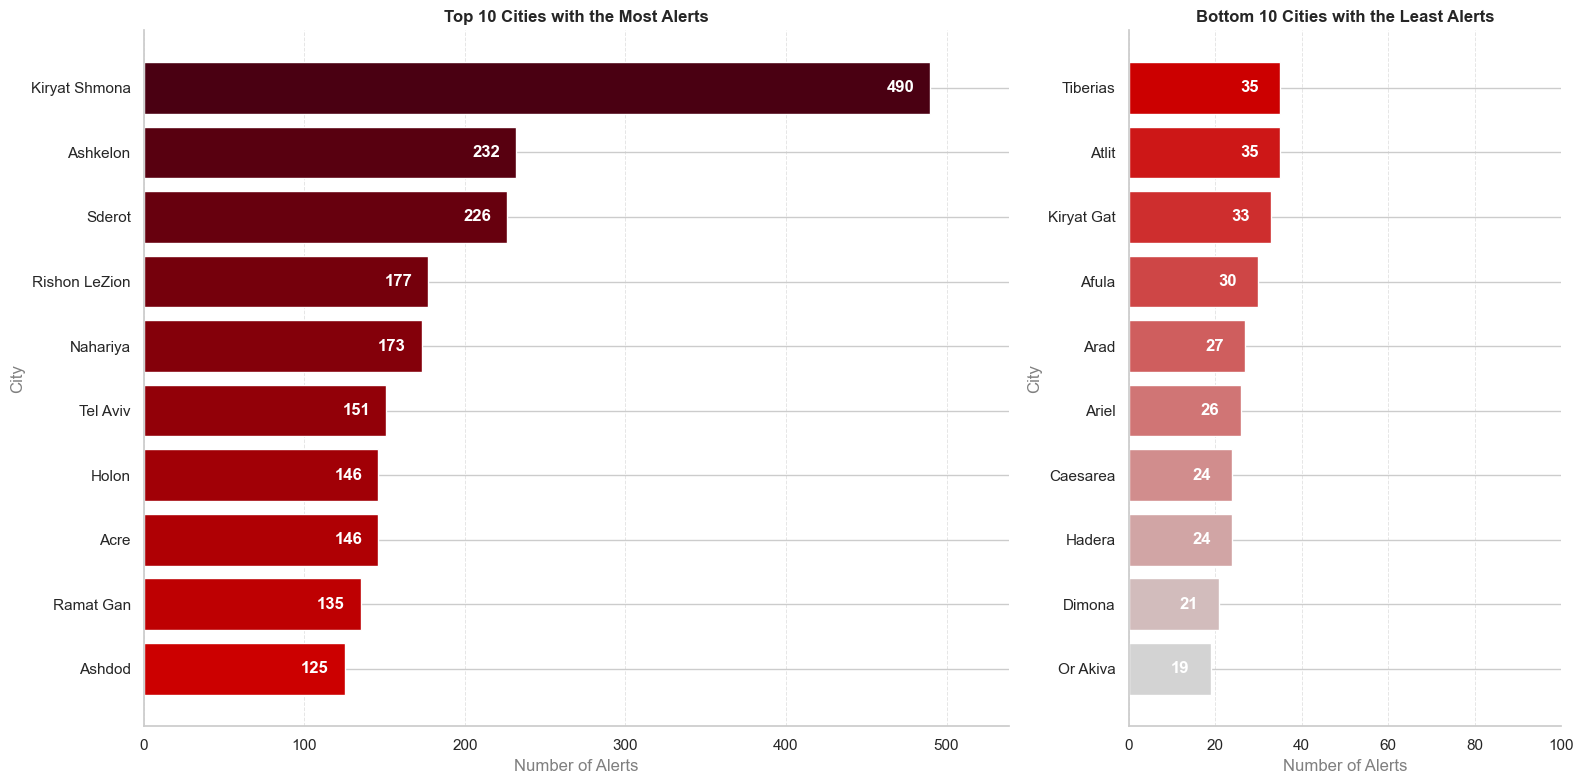

In [27]:
# Set a clean whitegrid style
sns.set_theme(style="whitegrid")

# Sort the data so that the largest "Number of Alerts" is first
top_cities_sorted = top_cities.sort_values("Number of Alerts", ascending=False).reset_index(drop=True)
bottom_cities_sorted = bottom_cities.sort_values("Number of Alerts", ascending=False).reset_index(drop=True)

# Create gradient palettes
# Top 10: from dark burgundy (#4A0012) to red (#CC0000)
top_colors = sns.blend_palette(["#4A0012", "#CC0000"], n_colors=len(top_cities_sorted))

# Bottom 10: from red (#CC0000) to gray (#999999)
bottom_colors = sns.blend_palette(["#CC0000", "#D3D3D3"], n_colors=len(bottom_cities_sorted))

# Determine a maximum for the top 10 x-axis
max_alerts = top_cities_sorted["Number of Alerts"].max()
x_limit_top = max_alerts * 1.1  # Add some space on the right

# Manually set the bottom 10 x-axis to 100
x_limit_bottom = 100

# Create subplots with a 2:1 width ratio
fig, (ax_top, ax_bottom) = plt.subplots(
    1, 2, figsize=(16, 8),
    gridspec_kw={'width_ratios': [2, 1]}
)

# ------------------------------------------------------------------------------
# Plot for Top 10 Cities
# ------------------------------------------------------------------------------
bars_top = ax_top.barh(
    y=top_cities_sorted["locality"], 
    width=top_cities_sorted["Number of Alerts"], 
    color=top_colors
)

# Invert y-axis so that the city with the largest alerts is on top
ax_top.invert_yaxis()

# Add numerical labels on each bar for Top 10
offset_top = max_alerts * 0.02
for bar, alerts in zip(bars_top, top_cities_sorted["Number of Alerts"]):
    x_pos = bar.get_width()
    y_pos = bar.get_y() + bar.get_height() / 2
    
    # Place label inside the bar
    ax_top.text(
        x_pos - offset_top, y_pos, 
        str(alerts),
        color='white', ha='right', va='center',
        fontweight='bold', fontsize=12
    )

# Customizing grid lines: thin, dashed, and semi-transparent
ax_top.grid(axis='x', linestyle='dashed', linewidth=0.7, alpha=0.5)

# Axis labels and title for top 10
ax_top.set_xlim(0, x_limit_top)
ax_top.set_title("Top 10 Cities with the Most Alerts", fontweight='bold')
ax_top.set_xlabel("Number of Alerts", color='gray')
ax_top.set_ylabel("City", color='gray')

# ------------------------------------------------------------------------------
# Plot for Bottom 10 Cities
# ------------------------------------------------------------------------------
bars_bottom = ax_bottom.barh(
    y=bottom_cities_sorted["locality"], 
    width=bottom_cities_sorted["Number of Alerts"], 
    color=bottom_colors
)

# Invert y-axis so that the city with the largest alerts in the bottom group is on top
ax_bottom.invert_yaxis()

# We will use a small offset and dynamically decide where to place the text
offset_bottom = x_limit_bottom * 0.05  # 5% of the chosen x-limit

# Add numerical labels on each bar for Bottom 10
for bar, alerts in zip(bars_bottom, bottom_cities_sorted["Number of Alerts"]):
    x_pos = bar.get_width()
    y_pos = bar.get_y() + bar.get_height() / 2
    
    # If the bar is wide enough to hold the text internally, place it inside
    if x_pos > offset_bottom:
        ax_bottom.text(
            x_pos - offset_bottom, y_pos, 
            str(alerts),
            color='white', ha='right', va='center',
            fontweight='bold', fontsize=12
        )
    else:
        # Otherwise, place the text just outside the bar, to the right
        ax_bottom.text(
            x_pos + (offset_bottom / 2), y_pos, 
            str(alerts),
            color='black', ha='left', va='center',
            fontweight='bold', fontsize=12
        )

# Customizing grid lines: thin, dashed, and semi-transparent
ax_bottom.grid(axis='x', linestyle='dashed', linewidth=0.7, alpha=0.5)

# Axis labels and title for bottom 10
ax_bottom.set_xlim(0, x_limit_bottom)
ax_bottom.set_title("Bottom 10 Cities with the Least Alerts", fontweight='bold')
ax_bottom.set_xlabel("Number of Alerts", color='gray')
ax_bottom.set_ylabel("City", color='gray')

# Remove spines for a cleaner look
sns.despine()

# Adjust spacing so titles and labels look good
plt.tight_layout()
plt.show()


In [28]:
# Display the full list of important cities with alert counts
alerts_by_city

,locality,Number of Alerts
0,Kiryat Shmona,490
1,Ashkelon,232
2,Sderot,226
3,Rishon LeZion,177
4,Nahariya,173
5,Tel Aviv,151
6,Holon,146
7,Acre,146
8,Ramat Gan,135
9,Ashdod,125


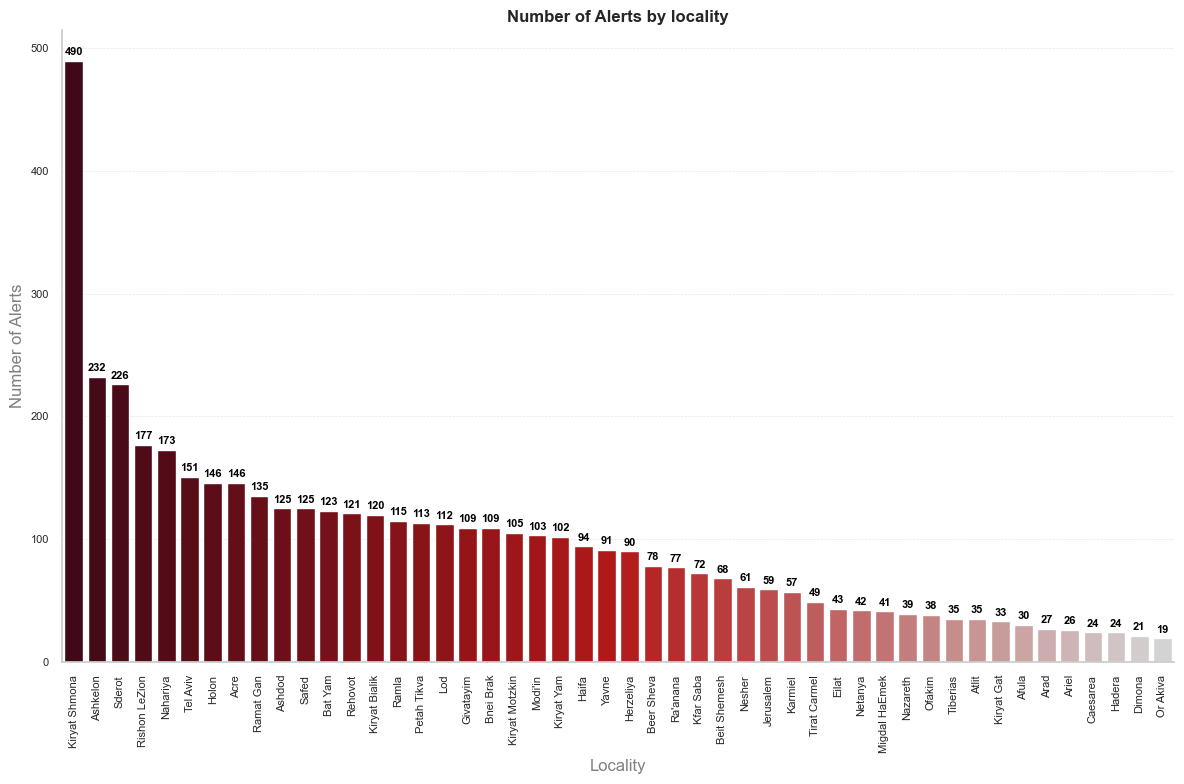

In [29]:
# Define a list of base colors for the gradient
base_colors = ["#4A0012", "#CC0000", "#D3D3D3"]

# Generate a custom gradient palette
colors = sns.blend_palette(base_colors, n_colors=len(alerts_by_city), as_cmap=False)

# Create figure
plt.figure(figsize=(12, 8))  

# Create a horizontal bar plot with a gradient color palette
ax = sns.barplot(
    data=alerts_by_city,
    y="Number of Alerts",  
    x="locality",          
    hue="locality",
    dodge=False,
    palette=colors,
    legend=False
)

# Add labels **above** each bar in black color
for container in ax.containers:
    for bar in container:
        y_pos = bar.get_height()  # Bar height
        x_pos = bar.get_x() + bar.get_width() / 2  # Center the label
        ax.text(
            x_pos, y_pos + 3,  # Always place text above the bar
            int(y_pos),
            ha='center', va='bottom',
            fontsize=8, color='black', fontweight='bold'
        )

# Customize plot appearance
ax.set_title("Number of Alerts by locality", fontweight='bold')
ax.set_ylabel("Number of Alerts", color='gray') 
ax.set_xlabel("Locality", color='gray')              

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, ha='center')

ax.tick_params(axis='both', which='major', labelsize=8)  # Reduce tick label size

# Customize grid lines: thin, dashed, and semi-transparent
ax.grid(axis='y', linestyle='dashed', linewidth=0.5, alpha=0.5)  

# Remove spines for a cleaner look
sns.despine()

# Adjust spacing so titles and labels look good
plt.tight_layout()
plt.savefig('localities.svg', bbox_inches='tight', format='svg')
plt.show()


Kiryat Shmona recorded the **highest number of red alerts — 490**, reflecting intense northern border activity.
Ashkelon (232) and Sderot (226) followed, showing high exposure in the **southern region**.
Central cities such as Rishon LeZion (177), Tel Aviv (151), and Haifa (94) had **moderate alert levels**, while Jerusalem (59) and Eilat (43) remained among the **least affected areas**.
Overall, the data indicates that **border towns face up to 10× higher alert frequency** compared to inland cities.


### Top-10 cities

A comparative analysis of the total number of alerts in the ten most significant cities

**City Selection Logic:**  
- **Ashkelon** – City with the highest number of alerts in the **south**.
- **Nahariya** - An important city on the **north** (with a high increase of attack).
- **Other cities** – The largest cities in Israel, ensuring broad geographical coverage.  

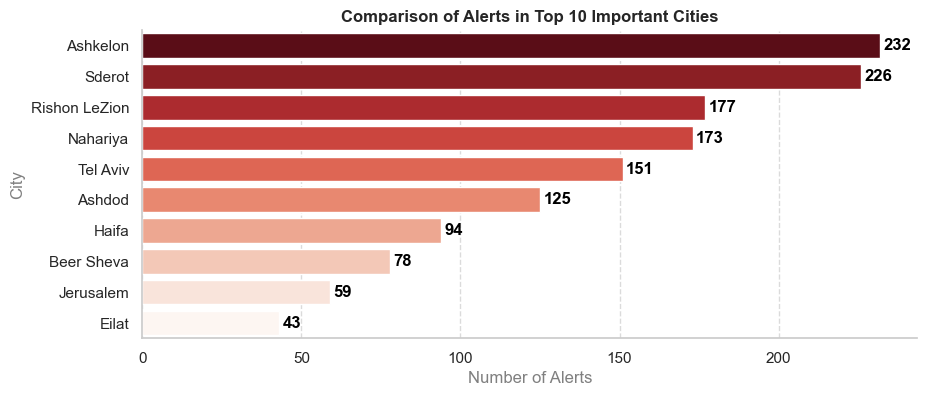

In [30]:
top_10_cities_list = [
    "Tel Aviv", "Jerusalem", "Haifa", "Beer Sheva", "Rishon LeZion",
    "Ashdod", "Ashkelon", "Sderot", "Nahariya", "Eilat"
]

# Filter the DataFrame to include only the top 10 cities
top_10_cities = df[df['locality'].isin(top_10_cities_list)]

# Count alerts by city
alerts_by_top_10_cities = top_10_cities['locality'].value_counts().reset_index()
alerts_by_top_10_cities.columns = ['City', 'Number of Alerts']

# Sort by the number of alerts in descending order
alerts_by_top_10_cities = alerts_by_top_10_cities.sort_values(
    by='Number of Alerts', ascending=False)

# Plot the comparison
plt.figure(figsize=(10, 4))
sns.barplot(data=alerts_by_top_10_cities, x="Number of Alerts", y="City", 
            hue=alerts_by_top_10_cities.index, palette="Reds_r", legend=False)

# Add labels
plt.title("Comparison of Alerts in Top 10 Important Cities", 
          fontweight='bold')
plt.xlabel("Number of Alerts", color='gray')
plt.ylabel("City", color='gray')

# Show numbers on bars
for index, value in enumerate(alerts_by_top_10_cities["Number of Alerts"]):
    plt.text(value + 1, index, str(value), ha="left", va="center", 
             fontweight="bold", fontsize=12, color="black")

plt.grid(axis='x', linestyle="--", alpha=0.7)
sns.despine()
plt.savefig('localities.svg', bbox_inches='tight', format='svg')
plt.show()


**Ashkelon (232)** and **Sderot (226)** recorded the highest number of alerts, showing significant exposure to southern border threats.
Major central cities such as **Rishon LeZion (177)**, **Tel Aviv (151)**, and **Haifa (94)** had moderate alert levels, while **Jerusalem (59)** and **Eilat (43)** remained among the least affected.

Now let's build a graph by year.

**Color Selection Logic:**
- South – Yellow to orange-red, distinct per city.
- North – Cool blue-gray, contrasting the warm south.
- Center – Red shades, with Tel Aviv brighter than Rishon LeZion.
- Jerusalem – Deep purple, emphasizing uniqueness.

In [31]:
city_colors = {
    "Tel Aviv":      "#C81E28",  # Bright red (central region)
    "Jerusalem":     "#6F2C6B",  # Deep purple (stands out)
    "Haifa":         "#4F7298",  # Cool medium blue (north)
    "Beer Sheva":    "#E07A29",  # Warm brownish-orange (south)
    "Rishon LeZion": "#A60D20",  # Dark red (central region), but lighter than Tel Aviv
    "Ashdod":        "#F16E43",  # Orange with a reddish undertone (south)
    "Ashkelon":      "#FF9642",  # Light orange (south)
    "Sderot":        "#FFCA28",  # Bright golden (south)
    "Nahariya": "#3B5E70",  # Dark grayish-blue (north)
    "Eilat":         "#FF3D2E"   # Rich orange-red (resort city, stands out)
}



# Group by (year, locality) and pivot so each row is a year and each column is a city
alerts_by_city_year = top_10_cities.groupby(
    [top_10_cities['datetime'].dt.year, 'locality']
).size().unstack(fill_value=0)

# Exclude years 2018 and 2025
alerts_by_city_year = alerts_by_city_year.loc[
    (alerts_by_city_year.index != 2018) ]

# Convert pivot to "long" form: columns -> (year, city, alerts)
df_melted = alerts_by_city_year.reset_index().melt(
    id_vars='datetime',  # pivot index (year) was named 'datetime' after reset_index
    var_name='city',
    value_name='alerts'
)

df_melted.rename(columns={'datetime': 'year'}, inplace=True)  # rename for clarity


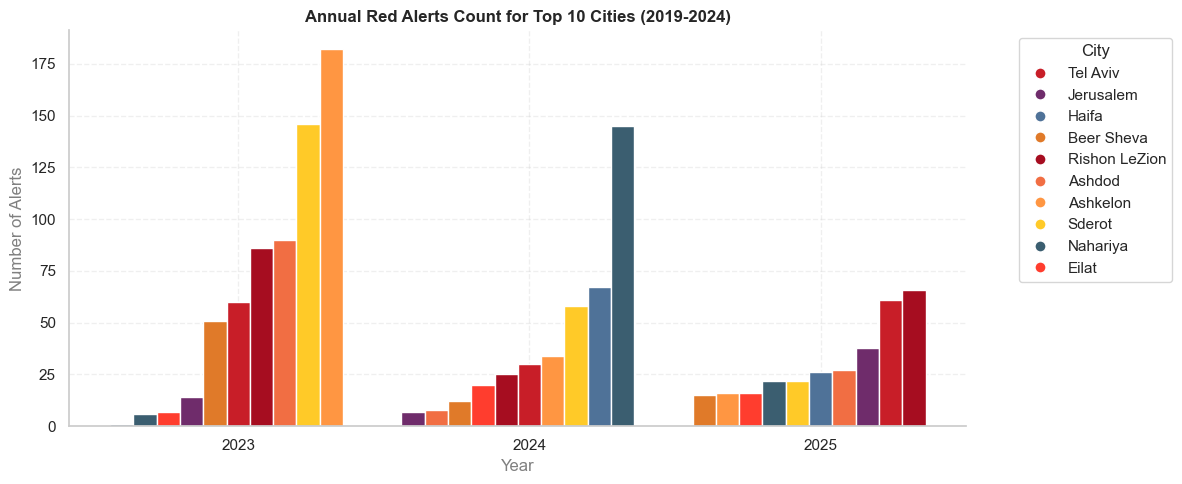

In [32]:
# Sort the years in ascending order
years = sorted(df_melted['year'].unique())

plt.figure(figsize=(12, 5))

# Define how wide each entire group will be on the x-axis
group_width = 0.8  
# We'll place each year's group center at x = i (i.e., 0, 1, 2, ...)

for i, year in enumerate(years):
    # Subset for this year
    sub = df_melted[df_melted['year'] == year].copy()
    # Sort the subset by alerts ascending
    sub.sort_values(by='alerts', inplace=True)
    
    # Now we have N cities for this year
    n = len(sub)
    # We'll place these bars in [i - group_width/2, i + group_width/2]
    # So each bar has width = group_width / n
    bar_width = group_width / n
    
    # Left edge for the first bar in this group
    left_edge = i - group_width/2
    
    # Plot each city’s bar
    for j, row in enumerate(sub.itertuples()):
        city = row.city
        alerts = row.alerts
        
        # X-position for this bar
        x_bar = left_edge + j * bar_width
        
        # Get the color for this city
        color = city_colors.get(city, 'gray')
        
        # Draw the bar
        plt.bar(x_bar, alerts, width=bar_width, color=color)
        

# X-axis: put tick marks at each integer i, label them by the year
plt.xticks(range(len(years)), years)

plt.xlabel("Year", color='gray')
plt.ylabel("Number of Alerts", color='gray')
plt.title("Annual Red Alerts Count for Top 10 Cities (2019-2024)", 
          fontweight='bold')

# Create a custom legend so each city retains the same color

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=city, 
           markerfacecolor=color, markersize=8) 
    for city, color in city_colors.items() 
    if city in df_melted['city'].unique()
]

plt.legend(
    handles=legend_elements,
    title="City",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

# Light dashed grid
plt.grid(axis='both', linestyle='--', alpha=0.3)

sns.despine()
plt.tight_layout()
plt.show()


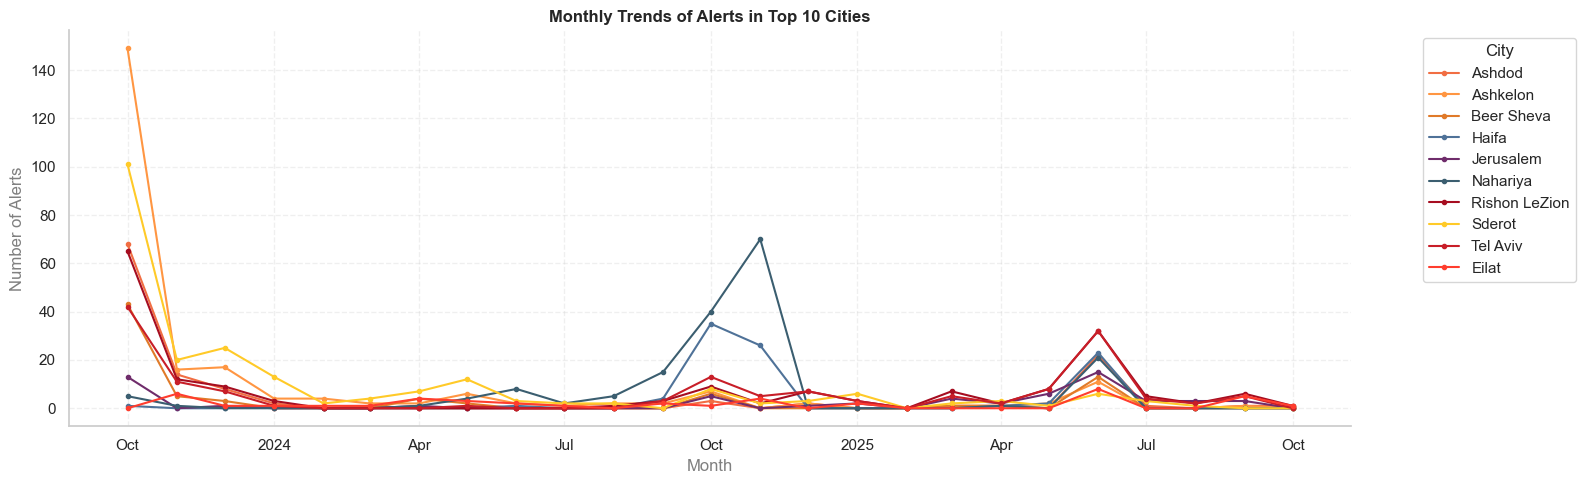

In [33]:
# Group data by month and city, counting the number of alerts
alerts_by_month_city = top_10_cities.groupby(
    [top_10_cities['datetime'].dt.to_period('M'), 'locality']
).size().reset_index()

alerts_by_month_city.columns = ['Month', 'City', 'Number of Alerts']
alerts_by_month_city['Month'] = alerts_by_month_city['Month'].astype(str)

# Convert 'Month' to datetime format (fixing the Period issue)
alerts_by_month_city['Month_dt'] = pd.to_datetime(alerts_by_month_city['Month'])

# Create a complete dataset with all month-city combinations
all_months = pd.date_range(
    start=alerts_by_month_city['Month_dt'].min(),
    end=alerts_by_month_city['Month_dt'].max(),
    freq='MS'  # 'MS' ensures we generate the start of each month
)

all_cities = alerts_by_month_city['City'].unique()

# Create a full dataframe with all possible month-city combinations
all_combinations = pd.DataFrame([(m, c) 
                                 for m in all_months for c in all_cities], 
                                columns=['Month_dt', 'City'])

# Merge with the original data and fill missing values with 0
alerts_by_month_city = all_combinations.merge(alerts_by_month_city, 
                                              on=['Month_dt', 'City'], 
                                              how='left'
                                             ).fillna(0)

# Set Seaborn style and context
sns.set_style("whitegrid")
sns.set_context("notebook")

# Create the figure and axis
plt.figure(figsize=(16, 5))
ax = plt.gca()


# Plot each city on the same axes
for city in alerts_by_month_city['City'].unique():
    city_data = alerts_by_month_city[alerts_by_month_city['City'] == city]
    plt.plot(
        city_data['Month_dt'],  # Now it's a proper datetime format
        city_data['Number of Alerts'],
        marker='o',
        markersize=3,                # Make markers smaller
        linewidth=1.5,               # Slightly thinner line
        color=city_colors.get(city, 'gray'),
        label=city
    )

# Axis labels and title
plt.xlabel("Month", color='gray')
plt.ylabel("Number of Alerts", color='gray')
plt.title("Monthly Trends of Alerts in Top 10 Cities", 
          fontweight='bold')

# Use AutoDateLocator and ConciseDateFormatter to space out and format date labels
locator = mdates.AutoDateLocator(minticks=3, maxticks=12)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# Rotate x-axis labels for readability
plt.xticks(rotation=0)

# Legend and grid
plt.legend(title="City", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='both', linestyle='--', alpha=0.3)

# Automatically adjust layout for a cleaner look
sns.despine()
plt.tight_layout()
plt.savefig("plot.png", dpi=300, bbox_inches='tight')
plt.show()


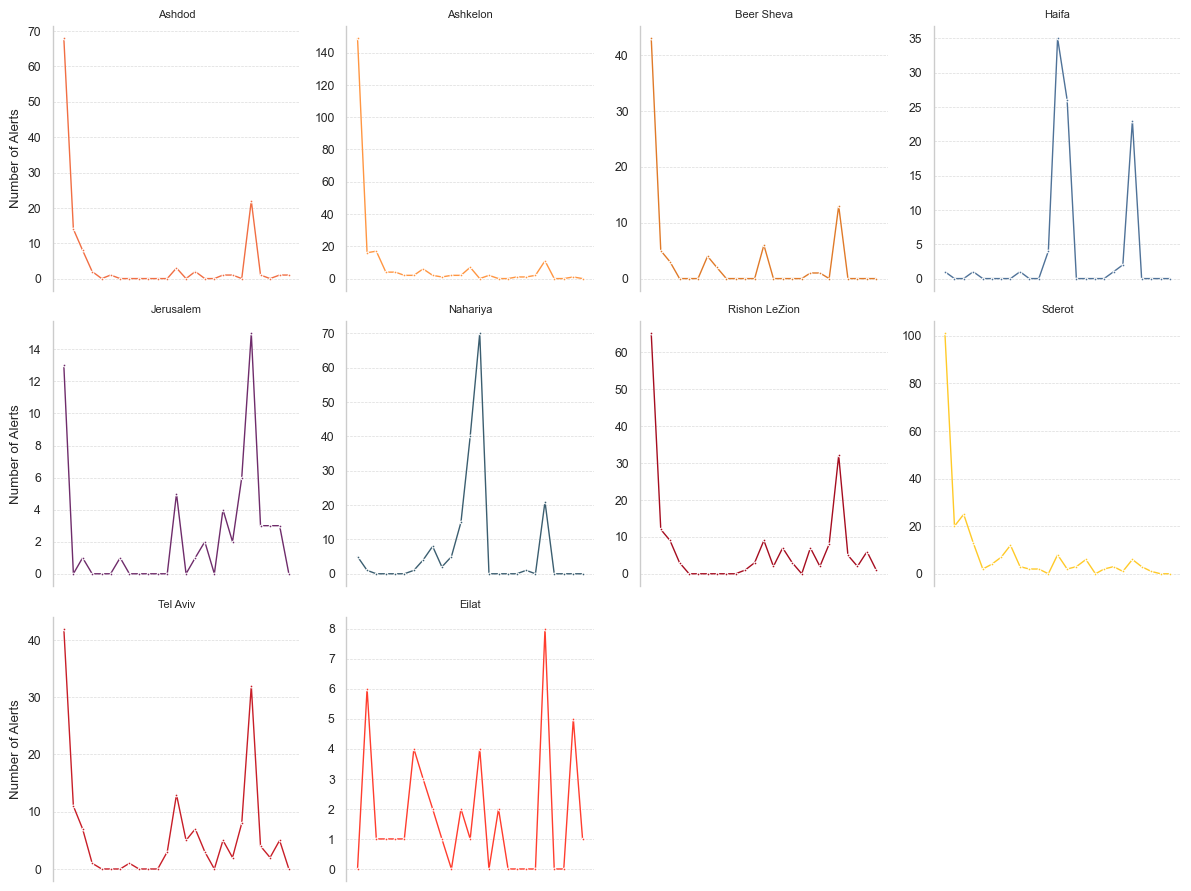

In [34]:
# Set Seaborn style & smaller context for compact visuals
sns.set_style("whitegrid")
sns.set_context("paper")  # Small font sizes for a cleaner look

# Custom function to plot each facet with the city-specific color
def plot_with_city_color(data, **kwargs):
    city_name = data['City'].iloc[0]
    color = city_colors.get(city_name, "gray")
    kwargs.pop("color", None)  # Avoid conflicts with automatic coloring
    
    sns.lineplot(
        data=data,
        x='Month_dt',
        y='Number of Alerts',
        marker='o',
        markersize=2,  # Smaller markers for a more delicate look
        linewidth=1,  # Thinner lines for a clean appearance
        color=color,
        **kwargs
    )

# Create a FacetGrid with smaller subplots
g = sns.FacetGrid(
    alerts_by_month_city,
    col="City",
    col_wrap=4,  # More cities in one row for better alignment
    height=3,  # Smaller subplots
    sharey=False,
    sharex=False
)

# Map our custom function to the FacetGrid
g.map_dataframe(plot_with_city_color)

# Titles: city names in smaller font
g.set_titles("{col_name}", size=8)

# Y-axis label remains, X-axis labels are removed
g.set_axis_labels("", "Number of Alerts")

# Remove x-axis ticks & labels to keep it clean
for ax in g.axes.flatten():
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlabel(None)
    
    # Set **dashed grid lines**
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)  
    
    sns.despine(ax=ax, left=False, bottom=True)  

# Adjust layout to avoid overlaps
plt.tight_layout()
plt.show()


In [35]:
# Print the alerts count for each city per year
alerts_by_city_year

locality,Ashdod,Ashkelon,Beer Sheva,Eilat,Haifa,Jerusalem,Nahariya,Rishon LeZion,Sderot,Tel Aviv
datetime,,,,,,,,,,
2023,90,182,51,7,1,14,6,86,146,60
2024,8,34,12,20,67,7,145,25,58,30
2025,27,16,15,16,26,38,22,66,22,61


In **2023**, **Ashkelon (182)**, **Sderot (146)**, and **Ashdod (90)** experienced the **highest alert activity**, marking a major escalation year.

In **2024**, overall alerts dropped sharply, but **Nahariya (145)** and **Haifa (67)** saw local surges, reflecting northern tension

.
By **2025**, alerts became more evenly distributed across cities, with moderate increases in **Jerusalem (38)** and **Rishon LeZion (66)** — suggesting a gradual shift from border zones to central and northern regions.


## 🚀 Types of Alarms

This section focuses on analyzing the different types of alarms recorded in the datasets. We will explore overall counts, temporal trends, and spatial distributions to gain insights into the alarm patterns.

### General Statistics

In [36]:
# Since 'Interception pieces' appears only once and does not repeat anywhere else, 
# it could be related to either 'Red Alert' or 'Unrecognized Aircraft'.
# For simplicity, we will rename it to 'Red Alert'.

detailed_df['threat_type'] = detailed_df['threat_type'].replace('Interception pieces', 'Red Alert')

In [37]:
# Count the number of alarms per threat type
alarm_counts = detailed_df['threat_type'].value_counts()
alarm_counts.to_frame()

,count
threat_type,
Red Alert,87613
Unrecognized Aircraft,8388
Earthquake,430
Terrorist Infiltration,46


In [38]:
# Calculate percentages
alarm_percentage = (alarm_counts / alarm_counts.sum()) * 100
alarm_percentage_formatted = alarm_percentage.map(lambda x: f"{x:.2f}%")

# Display the formatted percentages
print("Alarm Type Percentages")
alarm_percentage_formatted.to_frame()

Alarm Type Percentages


,count
threat_type,
Red Alert,90.81%
Unrecognized Aircraft,8.69%
Earthquake,0.45%
Terrorist Infiltration,0.05%


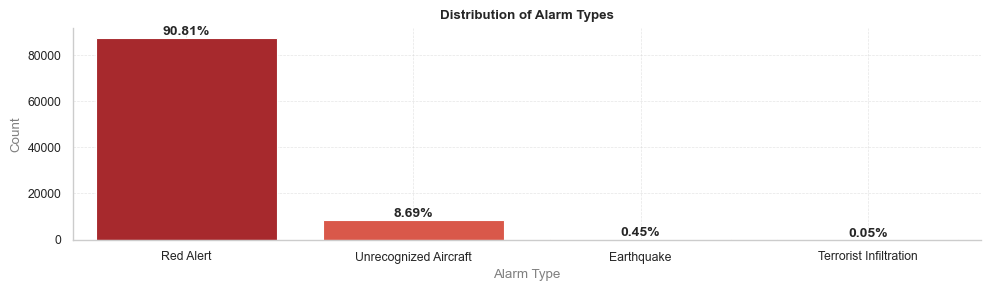

In [39]:
# Create the bar chart
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=alarm_counts.index, y=alarm_counts.values, 
                 hue=alarm_counts.index, palette="Reds_r", legend=False)

# Add percentage labels on top of each bar
for i, p in enumerate(ax.patches):
    ax.annotate(f"{alarm_percentage_formatted.iloc[i]}",  # Use iloc for positional indexing
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add dashed, thin, semi-transparent grid lines
ax.grid(True, which='major', linestyle='dashed', linewidth=0.5, alpha=0.5)

# Set titles and labels
plt.title("Distribution of Alarm Types", fontweight='bold')
plt.xlabel("Alarm Type", color='gray')
plt.ylabel("Count", color='gray')
plt.xticks(rotation=0)

# Show the plot
sns.despine()
plt.tight_layout()
plt.show()

The vast majority of alarms **(87613 or 90.81%)** were triggered by **Red Alerts**, indicating a high frequency of missile threats. **Unrecognized Aircraft** accounted for **8388 or 8.69%**, suggesting occasional unidentified aerial activity. **Earthquakes** and **Terrorist Infiltrations** were rare, making up **430 (0.45%)** and **46 (0.05%)**, respectively.  

In [40]:
# Counting the number of Unrecognized Aircrafts warnings by date
detailed_df[detailed_df['threat_type'] == 'Unrecognized Aircraft']['date'].value_counts()

date
2023-10-11    1038
2024-06-13     240
2025-06-15     209
2024-01-06     199
2024-07-04     172
              ... 
2025-01-09       1
2023-10-09       1
2024-06-26       1
2025-04-02       1
2024-05-15       1
Name: count, Length: 292, dtype: int64

The maximum number of alarms was 2023-10-11 (1038). It was a false alarm.

In [41]:
# Counting the number of earthquakes by date
detailed_df[detailed_df['threat_type'] == 'Terrorist Infiltration']['date'].value_counts().head(5)


date
2023-10-11    6
2023-10-24    5
2023-10-13    4
2023-10-14    3
2023-10-07    2
Name: count, dtype: int64

The maximum number of warnings about terrorist infiltration is 6, which occurred October 11 2023.


### Spatial Distribution

We will visualize the distribution of alarm types across different localities (cities) and identify local anomalies, such as areas with a high frequency of "Unrecognized Aircraft" warnings.

In [42]:
# Group by district and threat_type, then pivot
district_threat = detailed_df.groupby(['district', 'threat_type']).size().unstack(fill_value=0)

# Inspect the pivot table
district_threat


threat_type,Earthquake,Red Alert,Terrorist Infiltration,Unrecognized Aircraft
district,,,,
Central District,0,23040,3,47
Haifa District,27,5215,0,368
Jerusalem District,0,1209,0,0
Judea and Samaria Area,5,11087,29,60
Northern District,310,16207,0,2678
Southern District,88,26791,14,5225
Tel Aviv District,0,4064,0,10


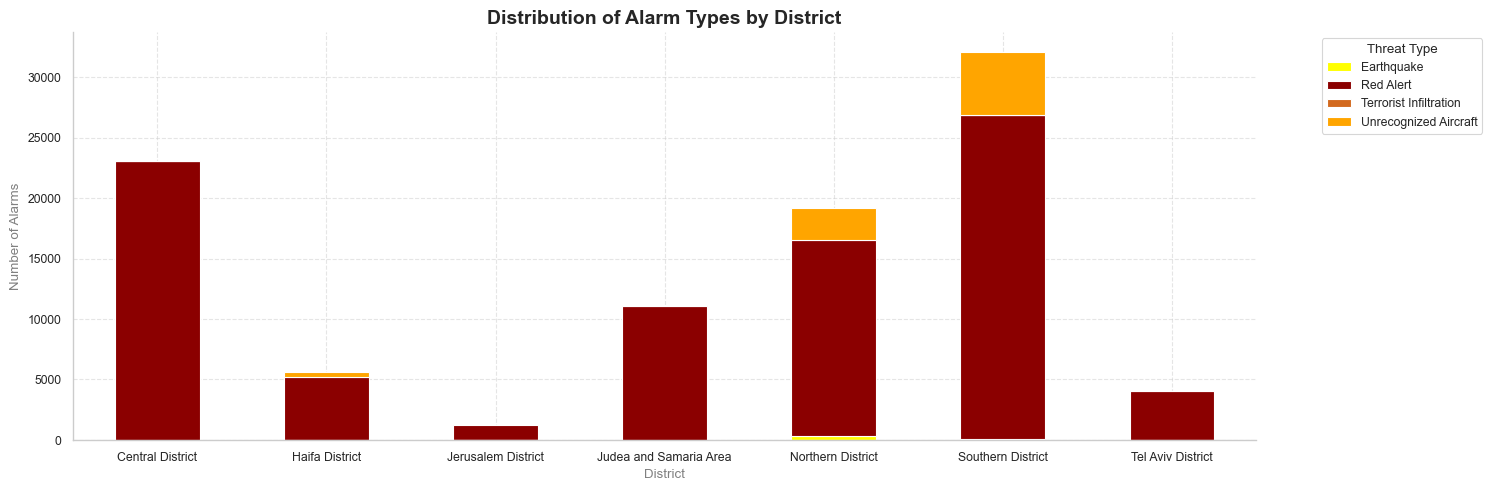

In [43]:
# Define custom colors for each threat type
threat_colors = {
    "Red Alert": "darkred",
    "Unrecognized Aircraft": "orange",
    "Terrorist Infiltration": "chocolate",
    "Earthquake": "yellow",
}

# Define colors in the order corresponding to district_threat columns
column_colors = [threat_colors.get(col, "gray") for col in district_threat.columns]

# Plot a stacked bar chart with custom colors
ax = district_threat.plot(kind='bar', stacked=True, figsize=(15, 5), color=column_colors)

# Title and labels
plt.title("Distribution of Alarm Types by District", size=14, fontweight='bold')
plt.xlabel("District", color='gray')
plt.ylabel("Number of Alarms", color='gray')

# Move the legend outside for clarity
plt.legend(title="Threat Type", bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate x-axis labels for better readability
plt.xticks(rotation=0)

# Customize grid: make it dashed and semi-transparent
ax.grid(visible=True, linestyle='dashed', alpha=0.5)

# Remove unnecessary spines for a cleaner look
sns.despine()

# Adjust layout
plt.tight_layout()

plt.savefig('alert_type.svg', bbox_inches='tight')  

# Show the plot
plt.show()


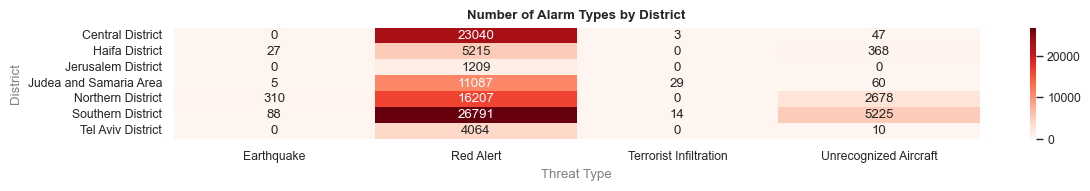

In [44]:
plt.figure(figsize=(12, 2))
sns.heatmap(district_threat, annot=True, fmt='d', cmap='Reds')
plt.title("Number of Alarm Types by District", fontweight='bold')
plt.xlabel("Threat Type", color='gray')
plt.ylabel("District", color='gray')
plt.tight_layout()
plt.savefig('my_plot.svg', bbox_inches='tight')  
plt.show()


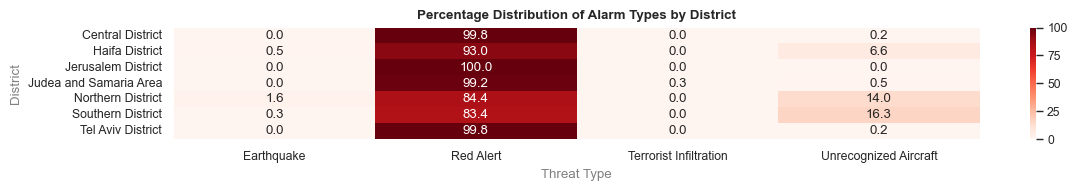

In [45]:
district_threat_perc = district_threat.apply(lambda row: row / row.sum(), axis=1) * 100

plt.figure(figsize=(12, 2))
sns.heatmap(district_threat_perc, annot=True, fmt=".1f", cmap='Reds')
plt.title("Percentage Distribution of Alarm Types by District", fontweight='bold')
plt.xlabel("Threat Type", color='gray')
plt.ylabel("District", color='gray')
plt.tight_layout()
plt.savefig('percentage.svg', bbox_inches='tight')
plt.show()


In [46]:
district_threat_perc

threat_type,Earthquake,Red Alert,Terrorist Infiltration,Unrecognized Aircraft
district,,,,
Central District,0.000000,99.783456,0.012993,0.203551
Haifa District,0.481283,92.959002,0.000000,6.559715
Jerusalem District,0.000000,100.000000,0.000000,0.000000
Judea and Samaria Area,0.044719,99.159288,0.259369,0.536625
Northern District,1.615004,84.433446,0.000000,13.951550
Southern District,0.273990,83.414285,0.043589,16.268136
Tel Aviv District,0.000000,99.754541,0.000000,0.245459



**Red Alerts** remain the dominant threat across nearly all districts.
The **Southern District** reports the **highest total alarm volume**, with **26,496 Red Alerts (83.41%)** and the **largest share of Unrecognized Aircraft warnings (16.23%)**, indicating both intense and diverse threat activity.
The **Northern District** shows a similar dual-risk profile, combining **15,735 Red Alerts (84.43%)** with a **notably high 13.95%** of **Unrecognized Aircraft** detections — the second-highest proportion.

In contrast, **Jerusalem** and **Tel Aviv Districts** are almost entirely composed of **Red Alerts (≈100%)**, reflecting a limited threat spectrum.
The **Judea and Samaria Area** stands out with the **highest rate of Terrorist Infiltrations (0.26%)**, a unique threat not prevalent elsewhere.
Meanwhile, the **Northern District** exhibits a small but notable share of **Earthquake-related warnings (1.76%)**, suggesting localized seismic sensitivity.

---

🔍 **Key Insight**

* **Southern District** — highest overall alert volume and most diverse threat mix.
* **Northern District** — major hotspot for **Unrecognized Aircraft** incidents.
* **Judea and Samaria Area** — uniquely impacted by **Terrorist Infiltrations**.
* **Jerusalem & Tel Aviv** — stable but uniformly dominated by **Red Alerts**, showing minimal variation in threat types.


## 🗺️ Geospatial Analysis

### By districts

In [47]:
# 1. Counting Alerts by Districts
alerts_by_district = detailed_df['district'].value_counts().reset_index()
alerts_by_district.columns = ['district', 'count']
print("Alerts count by district:")


alerts_by_district

Alerts count by district:


,district,count
0,Southern District,32118
1,Central District,23090
2,Northern District,19195
3,Judea and Samaria Area,11181
4,Haifa District,5610
5,Tel Aviv District,4074
6,Jerusalem District,1209


In [48]:
# Path to the GeoJSON file
#state_geo = r"docs/geoBoundaries-ISR-ADM1.geojson"
state_geo = r"C:/Users/Vera/Documents/geoBoundaries-ISR-ADM1.geojson"

# Load GeoJSON
with open(state_geo, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Display all available district names in GeoJSON
geojson_names = [feat["properties"]["shapeName"] for feat in data["features"]]
print("District names in GeoJSON:", geojson_names)

# Extract unique district names from alerts data
alerts_names = alerts_by_district["district"].unique()
print("District names in alerts_by_district:", alerts_names)

# Rename dictionary for district names
rename_districts = {
    'Southern District': 'Southern District',
    'Central District': 'Central District',
    'Northern District': 'Northern District',
    'Judea and Samaria Area': 'Judea and Samaria Area',  
    'Haifa': 'Haifa District',
    'Tel Aviv': 'Tel Aviv District',
    'Jerusalem District': 'Jerusalem District'
}

# Rename shapeName in GeoJSON
for feature in data["features"]:
    old_name = feature["properties"]["shapeName"]
    if old_name in rename_districts:
        feature["properties"]["shapeName"] = rename_districts[old_name]
    else:
        print(f"⚠️ No match found for {old_name}")

# Save the updated GeoJSON
updated_geojson_path = "C:/Users/Vera/Documents/updated_israel_districts.geojson"

with open(updated_geojson_path, 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=2)

print(f"✅ Updated GeoJSON saved to {updated_geojson_path}")


District names in GeoJSON: ['Southern District', 'Central District', 'Jerusalem District', 'Tel Aviv', 'Haifa', 'Northern District']
District names in alerts_by_district: ['Southern District' 'Central District' 'Northern District'
 'Judea and Samaria Area' 'Haifa District' 'Tel Aviv District'
 'Jerusalem District']
✅ Updated GeoJSON saved to C:/Users/Vera/Documents/updated_israel_districts.geojson


In [56]:
# Create a map centered on Israel
m = folium.Map(location=[31.0461, 34.8516], zoom_start=8, tiles='Cartodb Positron')

# Create a choropleth map
choropleth = folium.Choropleth(
    geo_data=updated_geojson_path,  # Using the updated file
    data=alerts_by_district,
    columns=['district', 'count'],
    key_on='feature.properties.shapeName',  # Must match GeoJSON
    fill_color='YlOrRd',
    fill_opacity=0.8,
    line_opacity=0.2,
    legend_name='Number of Alerts by District'
)

choropleth.add_to(m)

# Save and display the map
m.save("C:/Users/Vera/Documents/israel_choropleth_map.html")
#m

![Choropleth Map](docs/israel_choropleth_map_2years.png)

The result for the districts is quite approximate due to the large size of the districts, so we will build a heat map for the settlements.

In [50]:
# Initialize geolocator with a user agent and timeout
geolocator = Nominatim(user_agent="my_app", timeout=20)


def get_coordinates(city_name):
    """
    Attempts to retrieve coordinates using Nominatim.
    Appends ', Israel' to improve location accuracy.
    """
    query = f"{city_name}, Israel"
    try:
        location = geolocator.geocode(query, country_codes='il')
        if location:
            return location.latitude, location.longitude
        else:
#            print(f"Coordinates not found for: {city_name}")
            return None, None
    except Exception as e:
        print(f"Error during geocoding {city_name}: {e}")
        return None, None


# Dictionary of manually defined coordinates
manual_coords = {
    "Netiv HaAssara": (31.5708, 34.5394),
    "Nir Am Shooting Range": (31.5185, 34.5805),
    "Metzuba": (33.0633, 35.1583),
    "Kibutz Dan": (33.2403, 35.6531),
    "Nir Yitzhak": (31.23604, 34.356702),
    "Ma'a lot Tarshicha": (33.0167, 35.2708),
    "Be'er Yacov": (31.943507, 34.83904),
    "Ein Yacov": (33.0103, 35.2292),
    "Neveh Ziv": (33.0269, 35.1847),
    "Kannot Industrial Zone": (31.8014, 34.7514),
    "Zichron Yaakov": (32.5708, 34.9517),
    "Gush Etzion Junction": (31.64432, 35.15762),
    "Sha'ar Hanegev Industries": (31.51633, 34.59333),
    "Mevuot Hermon Regional Council": (31.9824446, 34.7651551),
    "Acco - Industrial Zone": (32.92817, 35.07564),
    "Akko New Cemetery": (32.92817, 35.07564),
    "Kiryat Biyalik": (32.8275, 35.0856),
    "Kiryat Bialik Industrial Zone": (32.8275, 35.0856),
    "Kfar Biyalik": (32.8211, 35.0875),
    "Dead Sea Factories": (31.0589, 35.6142),
    "Kiriyat Ono": (32.063599, 34.855301),
    "Netiv HaAssara": (31.5708, 34.5394)
}



In [51]:
def generate_heatmap(alerts_by_city, filename="docs/heatmap.html", zoom=8, radius=15):
    """
    Generates a heatmap from a DataFrame containing a 'locality' column.
    
    Parameters:
        df (DataFrame): The input dataset with a 'locality' column.
        filename (str): The name of the output HTML file.
        zoom (int): Initial zoom level of the map.
        radius (int): Radius of the heatmap points.
    
    Returns:
        folium.Map: The generated map object.
    """

    # Add columns for coordinates
    alerts_by_city['latitude'] = None
    alerts_by_city['longitude'] = None

    # Retrieve coordinates for each locality
    for index, row in alerts_by_city.iterrows():
        city = row['locality']
        
        # Use manual coordinates if available; otherwise, use geocoding
        if city in manual_coords:
            lat, lon = manual_coords[city]
        else:
            lat, lon = get_coordinates(city)
        
        alerts_by_city.at[index, 'latitude'] = lat
        alerts_by_city.at[index, 'longitude'] = lon
        
        # Delay to avoid rate limiting
        time.sleep(1)
    
    # Remove rows with missing coordinates
    city_data = alerts_by_city.dropna(subset=['latitude', 'longitude'])
    
    # Prepare data for the heatmap: [latitude, longitude, weight]
    heat_data = city_data[['latitude', 'longitude', 'Number of Alerts']].values.tolist()
    
    # Determine the map's center based on the average coordinates
    map_center = [city_data['latitude'].mean(), city_data['longitude'].mean()]
    
    # Initialize the map
    m = folium.Map(location=map_center, zoom_start=zoom)
    
    # Add the heatmap layer (adjust radius for better visualization)
    HeatMap(heat_data, radius=radius).add_to(m)
    
    # Save the map as an HTML file
    m.save(filename)
    print(f"The map has been successfully saved as {filename}")
    
    return m


To obtain a complete picture, let's build a map using data from the df dataset.

### By localities

In [52]:
# Aggregate data by locality:
alerts_by_city_df = df['locality'].value_counts().reset_index()
alerts_by_city_df.columns = ['locality', 'Number of Alerts']

# Generate a heatmap 
heatmap_all_cities = generate_heatmap(alerts_by_city_df, filename="heatmap_all_cities.html", 
                                      zoom=8, radius=15)

The map has been successfully saved as heatmap_all_cities.html


In [55]:
#print('Heatmap of alerts for all localities')
#heatmap_all_cities

**Heatmap of alerts for all localities**
![HeatMap](docs/heatmap_2_years.png)


Some location's coordinates could not be found, but the available results are sufficient to grasp the overall situation.

## ✅ General Conclusion

**Timeline & Escalation:**

* 📅 **Period:** October 7, 2023 – October 5, 2025; **Total Alerts:** 96477.
* ⏳ **Escalation:** The largest single-day peak occurred on **October 1, 2024** (**5,891 alerts**, during the Iranian attack), while the **highest sustained intensity** was recorded in **June 2025** (**37,770 alerts**), corresponding to the **Israel–Iran escalation**.

---

**Temporal Patterns:**

* 🔢 **Annual Trends:** **2025** registered the highest number of alerts (**51,127**), followed by **2024** with **32,674**, while **2023** marked the onset of escalation with **13,838 alerts**.
* 📆 **Monthly Trends:** Three major peaks in the dataset — **October 2023 (9,519 alerts)**, **October 2024 (13,404 alerts)**, and **June 2025 (37,770 alerts)**.
* 🕖 **Weekly Trends:**

  * **October 2023:** 4,968 alerts in one week
  * **October 2024:** 6,934 alerts in one week
  * **June 2025:** the sharpest surge — **16,670 alerts in a single week**, coinciding with the **Israel–Iran war peak**

---

**Geographical Shifts:**

* 🏙️ **Important Localities with the Most and Least Number of Alarms:**
  At the start of the conflict, southern cities such as **Ashkelon (232)**, **Sderot (226)**, **Ashdod (125)** were the most heavily targeted. Over time, however, the **epicenter of hostilities shifted northward**, reflecting changing threat dynamics.
  By **2025**, alerts became more geographically dispersed, with new spikes in **Jerusalem (38)** and **Rishon LeZion (66)** — indicating a **gradual expansion of threats from border regions toward central Israel**.

  * **Most Affected:** Northern border towns — **Kiryat Shmona (490)**, **Margaliot (385)**, and **Misgav Am (354)** — experienced the highest alert frequency.
  *  **Moderate Activity:** Central and coastal cities — **Rishon LeZion (177)**, **Tel Aviv (151)**, **Haifa (94)** — saw moderate levels of alerts.
  * 🕊 **Least Affected:** **Or Akiva (19)**, **Dimona (21)**, **Ariel (26)**, **Hadera (24)**, and **Caesarea (24)** remained largely stable throughout the period.

---

**Alarm Types & Spatial Distribution:**

* 🔴 **Dominant Alerts:** **Red Alerts (90.81%)** underscore the overwhelming prevalence of missile threats.
* ✈️ **Supplementary Alerts:** **Unrecognized Aircraft (8.69%)** and **Terrorist Infiltrations (0.05%)** contribute to the broader threat profile.
* 🌍 **Regional Insights:**

  -  The Southern District shows both high volume and variety of alerts.
  -  The Northern District experiences a higher share of aerial incidents.
  -  Areas like Judea and Samaria face unique risks, such as increased terrorist infiltration.

